# 實作

我們將注意力機制用在GNN中，實現GAT。

## 論文分類

搭建GAT模型，對數據集中的論文信息進行分析，使模型學習已有論文的分類特徵，以便預測出未知分類的論文類別。

### 載入套件

In [ ]:
from pathlib import Path 

import numpy as np
import pandas as pd
from scipy.sparse import coo_matrix,csr_matrix,diags,eye

import torch
from torch import nn
import torch.nn.functional as F

import matplotlib.pyplot as plt

### 載入數據集

使用CORA數據集，它是由機器學習的論文整理而來。

在該數據集中，記錄了每篇論文用到的關鍵詞，以及論文之間互相引用的關係。

論文共分為7類:
* 基於案例
* 遺傳算法
* 神經網絡
* 機率方法
* 強化學習
* 規則學習
* 理論

數據集中共有2708篇論文，每一篇論文都引用或至少被一篇其他論文所引用。

整個語料庫共有2708篇論文，同時，有將所有論文中，詞幹、停止詞、低頻詞刪除，留下1433個關鍵詞，作為論文的特體特徵。

* content文件包含以下格式的論文說明:

每列的第一條目，包含論文的為一字符串ID，隨後用一個二進制值，指示詞彙表中的每個單詞，在紙張中存在(1)或不存在(0)。列中的最後一項，包含紙張的類標籤。

* cites文件包含了語料庫的引文圖，每一列用以下格式，描述一個鏈接:

每列包含兩個紙張ID。第一條目是被引用論文的ID，第二條目是引用論文的ID。鏈接的方式是"從右向左"。例如，如果一列用"paper1 paper2"表示，則鏈接為"paper2→paper1"。

In [ ]:
# 解壓縮數據集

!unzip -q /content/drive/MyDrive/Datasets/cora.zip

In [ ]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print(device)

path = Path('./cora')
print(path)

cuda
cora


### 讀取並解析數據

In [ ]:
paper_features_label = np.genfromtxt(path/'cora.content', dtype=np.str)
print(paper_features_label,np.shape(paper_features_label))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: DeprecationWarning: `np.str` is a deprecated alias for the builtin `str`. To silence this warning, use `str` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.str_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  


[['31336' '0' '0' ... '0' '0' 'Neural_Networks']
 ['1061127' '0' '0' ... '0' '0' 'Rule_Learning']
 ['1106406' '0' '0' ... '0' '0' 'Reinforcement_Learning']
 ...
 ['1128978' '0' '0' ... '0' '0' 'Genetic_Algorithms']
 ['117328' '0' '0' ... '0' '0' 'Case_Based']
 ['24043' '0' '0' ... '0' '0' 'Neural_Networks']] (2708, 1435)


2708代表論文數量，每篇論文共有1435個屬性。

In [ ]:
papers = paper_features_label[:,0].astype(np.int32)
print(papers)

[  31336 1061127 1106406 ... 1128978  117328   24043]


In [ ]:
paper2idx = {k:v for v,k in enumerate(papers)}
print(paper2idx)

{31336: 0, 1061127: 1, 1106406: 2, 13195: 3, 37879: 4, 1126012: 5, 1107140: 6, 1102850: 7, 31349: 8, 1106418: 9, 1123188: 10, 1128990: 11, 109323: 12, 217139: 13, 31353: 14, 32083: 15, 1126029: 16, 1118017: 17, 49482: 18, 753265: 19, 249858: 20, 1113739: 21, 48766: 22, 646195: 23, 1126050: 24, 59626: 25, 340299: 26, 354004: 27, 242637: 28, 1106492: 29, 74975: 30, 1152272: 31, 100701: 32, 66982: 33, 13960: 34, 13966: 35, 66990: 36, 182093: 37, 182094: 38, 13972: 39, 13982: 40, 16819: 41, 273152: 42, 237521: 43, 1153703: 44, 32872: 45, 284025: 46, 218666: 47, 16843: 48, 1153724: 49, 1153728: 50, 158098: 51, 8699: 52, 1134865: 53, 28456: 54, 248425: 55, 1112319: 56, 28471: 57, 175548: 58, 696345: 59, 28485: 60, 1139195: 61, 35778: 62, 28491: 63, 310530: 64, 1153784: 65, 1481: 66, 1153786: 67, 13212: 68, 1111614: 69, 5055: 70, 4329: 71, 330148: 72, 1105062: 73, 4330: 74, 5062: 75, 4335: 76, 158812: 77, 40124: 78, 1103610: 79, 688361: 80, 302545: 81, 20534: 82, 1031453: 83, 5086: 84, 193742

In [ ]:
features = csr_matrix(paper_features_label[:, 1:-1], dtype=np.float32)
print(np.shape(features))

(2708, 1433)


2708代表論文數量，1433代表有1433個關鍵字，在每篇論文中的出現情況，出現為1，沒出現為0。

In [ ]:
labels = paper_features_label[:, -1]
lbl2idx = {k:v for v,k in enumerate(sorted(np.unique(labels)))}
labels = [lbl2idx[e] for e in labels]
print(lbl2idx,labels[:5])

{'Case_Based': 0, 'Genetic_Algorithms': 1, 'Neural_Networks': 2, 'Probabilistic_Methods': 3, 'Reinforcement_Learning': 4, 'Rule_Learning': 5, 'Theory': 6} [2, 5, 4, 4, 3]


### 讀取並解析關係數據

將每篇論文當作一個頂點，論文間的引用關係作為邊，這樣論文的關係數據，就可以用一個圖結構來表示。

我們要計算該圖結構的鄰接矩陣，並將其轉為無向圖的鄰接矩陣。

數據集中的論文引用關係數組:

In [ ]:
edges = np.genfromtxt(path/'cora.cites', dtype=np.int32)
print(edges,np.shape(edges))

[[     35    1033]
 [     35  103482]
 [     35  103515]
 ...
 [ 853118 1140289]
 [ 853155  853118]
 [ 954315 1155073]] (5429, 2)


將論文ID換為重新編號後的引用關係數組:

In [ ]:
edges = np.asarray([paper2idx[e] for e in edges.flatten()], np.int32).reshape(edges.shape)
print(edges,edges.shape)

[[ 163  402]
 [ 163  659]
 [ 163 1696]
 ...
 [1887 2258]
 [1902 1887]
 [ 837 1686]] (5429, 2)


針對由論文引用關係所表示的圖結構，生成鄰接矩陣:

In [ ]:
adj = coo_matrix((np.ones(edges.shape[0]), (edges[:, 0], edges[:, 1])),
                 shape=(len(labels), len(labels)), dtype=np.float32)
adj
# Symmetric adjacency matrix
#adj = adj + adj.T.multiply(adj.T > adj) - adj.multiply(adj.T > adj)

<2708x2708 sparse matrix of type '<class 'numpy.float32'>'
	with 5429 stored elements in COOrdinate format>

將有向圖的鄰接矩陣，轉為無向圖的鄰接矩陣:

In [ ]:
adj_long = adj.multiply(adj.T < adj)
adj = adj_long+adj_long.T
adj

<2708x2708 sparse matrix of type '<class 'numpy.float32'>'
	with 10254 stored elements in Compressed Sparse Row format>

**Note**: 
* 因為任務是對論文進行分類，所以論文間的引用關係，為模型提供了單個論文特徵之間的關聯。
* 因為在模型處理過程中，更看重的是論文之間有沒有聯繫，所以要用無向圖表示

### 加工圖結構

對圖結構的矩陣進行加工，使其更好地表現出圖結構的特徵，並參與神經網絡的模型計算。

實現對鄰接矩陣進行，對稱正規化拉普拉斯矩陣的轉化。

In [ ]:
def normalize(mx):
    '''Row-normalize sparse matrix'''
    rowsum = np.array(mx.sum(1))
    r_inv = (rowsum ** -1).flatten() 
    r_inv[np.isinf(r_inv)] = 0.
    r_mat_inv = diags(r_inv)
    mx = r_mat_inv.dot(mx)
    return mx

features = normalize(features)

def normalize_adj(mx):
    """Row-normalize sparse matrix"""
    rowsum = np.array(mx.sum(1))
    r_inv = np.power(rowsum, -0.5).flatten()
    r_inv[np.isinf(r_inv)] = 0.
    r_mat_inv = diags(r_inv)
    return mx.dot(r_mat_inv).transpose().dot(r_mat_inv)

#adj = normalize(adj + eye(adj.shape[0]))
adj = normalize_adj(adj + eye(adj.shape[0]))

### 將數據轉為張量

將加工好的圖結構矩陣數據，轉為PyTorch支持的張量類型。

將數據集分為訓練、驗證，以及測試，三個部分。

In [ ]:
# Data as tensors
adj = torch.FloatTensor(adj.todense()) 
features = torch.FloatTensor(features.todense())
labels = torch.LongTensor(labels) 

n_train = 200
n_val = 300
n_test = len(features) - n_train - n_val
np.random.seed(34)
idxs = np.random.permutation(len(features))

idx_train = torch.LongTensor(idxs[:n_train])
idx_val   = torch.LongTensor(idxs[n_train:n_train+n_val])
idx_test  = torch.LongTensor(idxs[n_train+n_val:])

adj = adj.to(device)
features = features.to(device)
labels = labels.to(device)
idx_train = idx_train.to(device)
idx_val = idx_val.to(device)
idx_test = idx_test.to(device)

In [ ]:
n_labels = labels.max().item() + 1  
n_features = features.shape[1]   
print(n_labels, n_features)

7 1433


### Mish啟動函數

In [ ]:
def mish(x):					
    return x *( torch.tanh(F.softplus(x)))

### 定義圖注意力網絡

In [ ]:
class GraphAttentionLayer(nn.Module): # 定義圖注意力層

    def __init__(self, in_features, out_features, dropout=0.6):
        super(GraphAttentionLayer, self).__init__()
        self.dropout = dropout
        self.in_features = in_features # 輸入特徵維度
        self.out_features = out_features # 輸出特徵維度
        self.W = nn.Parameter(torch.zeros(size=(in_features, out_features)))
        nn.init.xavier_uniform_(self.W) # 初始化全連接權重
        self.a = nn.Parameter(torch.zeros(size=(2*out_features, 1))) 
        nn.init.xavier_uniform_(self.a) # 初始化注意力權重

    def forward(self, input, adj): # 正向傳播
        h = torch.mm(input, self.W) # 全連接處理
        N = h.size()[0]

        # 將全連接後的特徵數據，分別進行基於批次維度和特徵維度的複製，並將複製結果連接在一起
        # 這使得頂點中的特徵數據，進行了充分的排列組合，結果中的每列信息，都包含兩個頂點特徵
        a_input = torch.cat([h.repeat(1, N).view(N * N, -1), h.repeat(N, 1)], dim=1).view(N, -1, 2 * self.out_features) 
        e = mish(torch.matmul(a_input, self.a).squeeze(2))# 計算注意力，[N,N]
        
        
        
        zero_vec = -9e15*torch.ones_like(e) # 初始化最小值
        attention = torch.where(adj > 0, e, zero_vec) # 過濾注意力，如果對過濾掉的特徵值賦為0，則模型會無法收斂
        # print(attention )
        attention = F.softmax(attention, dim=1) # 對注意力分數，進行正規化，得到注意力分數
        attention = F.dropout(attention, self.dropout, training=self.training) # 使用注意力，處理特徵
        h_prime = torch.matmul(attention, h)
        return mish(h_prime)

### 定義GAT

In [ ]:
class GAT(nn.Module):
    def __init__(self,nfeat,  nclass,nhid, dropout,  nheads):
        super(GAT, self).__init__()

        # 注意力層
        self.attentions = [GraphAttentionLayer(nfeat, nhid,dropout) for _ in range(nheads)]
        for i, attention in enumerate(self.attentions): # 添加到模型中
            self.add_module('attention_{}'.format(i), attention)
        # 輸出層
        self.out_att = GraphAttentionLayer(nhid * nheads, nclass, dropout)

    def forward(self, x, adj): # 正向傳播
        x = torch.cat([att(x, adj) for att in self.attentions], dim=1) # 依次調用注意力層，將結果連接起來
        return self.out_att(x, adj)

### 定義相關函數

注意，在GAT中，無論是用模型進行預測還是訓練，都需要將全部的圖結構矩陣輸入。

In [ ]:
def accuracy(output,y):
    return (output.argmax(1) == y).type(torch.float32).mean().item()

def step():
    model.train()
    optimizer.zero_grad()
    output = model(features, adj)
    loss = F.cross_entropy(output[idx_train], labels[idx_train])
    acc = accuracy(output[idx_train], labels[idx_train])
    loss.backward()
    optimizer.step()
    return loss.item(), acc

def evaluate(idx):
    model.eval()
    output = model(features, adj)
    loss = F.cross_entropy(output[idx], labels[idx]).item()
    return loss, accuracy(output[idx], labels[idx])

### 定義Ranger優化器

In [ ]:
import math
import torch
from torch.optim.optimizer import Optimizer, required
import itertools as it



class Ranger(Optimizer):

    def __init__(self, params, lr=1e-3, alpha=0.5, k=6, N_sma_threshhold=5, betas=(.95,0.999), eps=1e-5, weight_decay=0):
        #parameter checks
        if not 0.0 <= alpha <= 1.0:
            raise ValueError(f'Invalid slow update rate: {alpha}')
        if not 1 <= k:
            raise ValueError(f'Invalid lookahead steps: {k}')
        if not lr > 0:
            raise ValueError(f'Invalid Learning Rate: {lr}')
        if not eps > 0:
            raise ValueError(f'Invalid eps: {eps}')

        defaults = dict(lr=lr, alpha=alpha, k=k, step_counter=0, betas=betas, N_sma_threshhold=N_sma_threshhold, eps=eps, weight_decay=weight_decay)
        super().__init__(params,defaults)

        self.N_sma_threshhold = N_sma_threshhold

        #for group in self.param_groups:
        #    group["step_counter"] = 0
            #print("group step counter init")

        self.alpha = alpha
        self.k = k 

        self.radam_buffer = [[None,None,None] for ind in range(10)]

        #self.first_run_check=0

        #self.slow_weights = [[p.clone().detach() for p in group['params']]
        #                     for group in self.param_groups]

        #for w in it.chain(*self.slow_weights):
        #    w.requires_grad = False

    def __setstate__(self, state):
        print("set state called")
        super(Ranger, self).__setstate__(state)


    def step(self, closure=None):
        loss = None

        #if closure is not None:
            #loss = closure()

        for group in self.param_groups:

            for p in group['params']:
                if p.grad is None:
                    continue
                grad = p.grad.data.float()
                if grad.is_sparse:
                    raise RuntimeError('Ranger optimizer does not support sparse gradients')

                p_data_fp32 = p.data.float()

                state = self.state[p]  #get state dict for this param

                if len(state) == 0:   #if first time to run...init dictionary with our desired entries
                    #if self.first_run_check==0:
                        #self.first_run_check=1
                        #print("Initializing slow buffer...should not see this at load from saved model!")
                    state['step'] = 0
                    state['exp_avg'] = torch.zeros_like(p_data_fp32)
                    state['exp_avg_sq'] = torch.zeros_like(p_data_fp32)

                    #look ahead weight storage now in state dict 
                    state['slow_buffer'] = torch.empty_like(p.data)
                    state['slow_buffer'].copy_(p.data)

                else:
                    state['exp_avg'] = state['exp_avg'].type_as(p_data_fp32)
                    state['exp_avg_sq'] = state['exp_avg_sq'].type_as(p_data_fp32)

                #begin computations 
                exp_avg, exp_avg_sq = state['exp_avg'], state['exp_avg_sq']
                beta1, beta2 = group['betas']

                #compute variance mov avg
                exp_avg_sq.mul_(beta2).addcmul_(1 - beta2, grad, grad)
                #compute mean moving avg
                exp_avg.mul_(beta1).add_(1 - beta1, grad)

                state['step'] += 1


                buffered = self.radam_buffer[int(state['step'] % 10)]
                if state['step'] == buffered[0]:
                    N_sma, step_size = buffered[1], buffered[2]
                else:
                    buffered[0] = state['step']
                    beta2_t = beta2 ** state['step']
                    N_sma_max = 2 / (1 - beta2) - 1
                    N_sma = N_sma_max - 2 * state['step'] * beta2_t / (1 - beta2_t)
                    buffered[1] = N_sma
                    if N_sma > self.N_sma_threshhold:
                        step_size = math.sqrt((1 - beta2_t) * (N_sma - 4) / (N_sma_max - 4) * (N_sma - 2) / N_sma * N_sma_max / (N_sma_max - 2)) / (1 - beta1 ** state['step'])
                    else:
                        step_size = 1.0 / (1 - beta1 ** state['step'])
                    buffered[2] = step_size

                if group['weight_decay'] != 0:
                    p_data_fp32.add_(-group['weight_decay'] * group['lr'], p_data_fp32)

                if N_sma > self.N_sma_threshhold:
                    denom = exp_avg_sq.sqrt().add_(group['eps'])
                    p_data_fp32.addcdiv_(-step_size * group['lr'], exp_avg, denom)
                else:
                    p_data_fp32.add_(-step_size * group['lr'], exp_avg)

                p.data.copy_(p_data_fp32)

                if state['step'] % group['k'] == 0:
                    slow_p = state['slow_buffer'] #get access to slow param tensor
                    slow_p.add_(self.alpha, p.data - slow_p)  #(fast weights - slow weights) * alpha
                    p.data.copy_(slow_p)  #copy interpolated weights to RAdam param tensor

        return loss

### 訓練模型

In [ ]:
model = GAT(n_features, n_labels, 
            16, # 輸出維度
            0.1, # 丟棄率
            8 # 注意力的計算套數
            ).to(device)

# 如果模型占用的顯存太大，則可以進行縮小:
# model = GAT(n_features, n_labels, 
#             8, # 輸出維度
#             0.1, # 丟棄率
#             4 # 注意力的計算套數
#             ).to(device)

In [ ]:
optimizer = Ranger(model.parameters())


from tqdm import tqdm  #pip install tqdm

epochs = 3000

print_steps = 50
train_loss, train_acc = [], []
val_loss, val_acc = [], []
for i in tqdm(range(epochs)):
    tl, ta = step()
    train_loss += [tl]
    train_acc += [ta]
    if (i+1)%print_steps == 0 or i == 0:
        tl, ta = evaluate(idx_train)
        vl, va = evaluate(idx_val)
        val_loss += [vl]
        val_acc += [va]
        print(f'{i+1:6d}/{epochs}: train_loss={tl:.4f}, train_acc={ta:.4f}'+
              f', val_loss={vl:.4f}, val_acc={va:.4f}')

  0%|          | 0/3000 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:107: UserWarning: This overload of addcmul_ is deprecated:
	addcmul_(Number value, Tensor tensor1, Tensor tensor2)
Consider using one of the following signatures instead:
	addcmul_(Tensor tensor1, Tensor tensor2, *, Number value) (Triggered internally at  ../torch/csrc/utils/python_arg_parser.cpp:1174.)
  0%|          | 1/3000 [00:03<2:53:57,  3.48s/it]

     1/3000: train_loss=1.9460, train_acc=0.1150, val_loss=1.9461, val_acc=0.0833


  2%|▏         | 50/3000 [00:24<27:29,  1.79it/s]

    50/3000: train_loss=1.9446, train_acc=0.2250, val_loss=1.9449, val_acc=0.1733


  3%|▎         | 100/3000 [00:46<27:11,  1.78it/s]

   100/3000: train_loss=1.9408, train_acc=0.5550, val_loss=1.9420, val_acc=0.5100


  5%|▌         | 150/3000 [01:07<27:01,  1.76it/s]

   150/3000: train_loss=1.9358, train_acc=0.6200, val_loss=1.9381, val_acc=0.5667


  7%|▋         | 200/3000 [01:29<26:46,  1.74it/s]

   200/3000: train_loss=1.9276, train_acc=0.6650, val_loss=1.9318, val_acc=0.5800


  8%|▊         | 250/3000 [01:51<26:05,  1.76it/s]

   250/3000: train_loss=1.9157, train_acc=0.6500, val_loss=1.9225, val_acc=0.5800


 10%|█         | 300/3000 [02:13<25:35,  1.76it/s]

   300/3000: train_loss=1.9007, train_acc=0.6400, val_loss=1.9107, val_acc=0.5867


 12%|█▏        | 350/3000 [02:35<25:07,  1.76it/s]

   350/3000: train_loss=1.8767, train_acc=0.6250, val_loss=1.8917, val_acc=0.5733


 13%|█▎        | 400/3000 [02:57<24:38,  1.76it/s]

   400/3000: train_loss=1.8423, train_acc=0.6200, val_loss=1.8646, val_acc=0.5633


 15%|█▌        | 450/3000 [03:19<24:10,  1.76it/s]

   450/3000: train_loss=1.8005, train_acc=0.6200, val_loss=1.8318, val_acc=0.5633


 17%|█▋        | 500/3000 [03:41<23:43,  1.76it/s]

   500/3000: train_loss=1.7366, train_acc=0.6250, val_loss=1.7824, val_acc=0.5700


 18%|█▊        | 550/3000 [04:03<23:14,  1.76it/s]

   550/3000: train_loss=1.6520, train_acc=0.6500, val_loss=1.7181, val_acc=0.5900


 20%|██        | 600/3000 [04:25<22:47,  1.76it/s]

   600/3000: train_loss=1.5592, train_acc=0.7000, val_loss=1.6492, val_acc=0.6167


 22%|██▏       | 650/3000 [04:46<22:17,  1.76it/s]

   650/3000: train_loss=1.4373, train_acc=0.7400, val_loss=1.5608, val_acc=0.6367


 23%|██▎       | 700/3000 [05:08<21:48,  1.76it/s]

   700/3000: train_loss=1.3033, train_acc=0.7800, val_loss=1.4660, val_acc=0.6733


 25%|██▌       | 750/3000 [05:30<21:20,  1.76it/s]

   750/3000: train_loss=1.1810, train_acc=0.8050, val_loss=1.3808, val_acc=0.6867


 27%|██▋       | 800/3000 [05:52<20:53,  1.76it/s]

   800/3000: train_loss=1.0447, train_acc=0.8450, val_loss=1.2850, val_acc=0.7100


 28%|██▊       | 850/3000 [06:14<20:24,  1.76it/s]

   850/3000: train_loss=0.9146, train_acc=0.8750, val_loss=1.1920, val_acc=0.7433


 30%|███       | 900/3000 [06:36<19:54,  1.76it/s]

   900/3000: train_loss=0.8062, train_acc=0.9200, val_loss=1.1132, val_acc=0.7667


 32%|███▏      | 950/3000 [06:58<19:24,  1.76it/s]

   950/3000: train_loss=0.6937, train_acc=0.9350, val_loss=1.0303, val_acc=0.7867


 33%|███▎      | 1000/3000 [07:20<18:56,  1.76it/s]

  1000/3000: train_loss=0.5932, train_acc=0.9400, val_loss=0.9560, val_acc=0.7933


 35%|███▌      | 1050/3000 [07:42<18:29,  1.76it/s]

  1050/3000: train_loss=0.5144, train_acc=0.9550, val_loss=0.8979, val_acc=0.8033


 37%|███▋      | 1100/3000 [08:03<18:01,  1.76it/s]

  1100/3000: train_loss=0.4370, train_acc=0.9650, val_loss=0.8423, val_acc=0.8100


 38%|███▊      | 1150/3000 [08:25<17:32,  1.76it/s]

  1150/3000: train_loss=0.3723, train_acc=0.9700, val_loss=0.7957, val_acc=0.8200


 40%|████      | 1200/3000 [08:47<17:04,  1.76it/s]

  1200/3000: train_loss=0.3242, train_acc=0.9750, val_loss=0.7612, val_acc=0.8300


 42%|████▏     | 1250/3000 [09:09<16:35,  1.76it/s]

  1250/3000: train_loss=0.2780, train_acc=0.9750, val_loss=0.7292, val_acc=0.8300


 43%|████▎     | 1300/3000 [09:31<16:06,  1.76it/s]

  1300/3000: train_loss=0.2391, train_acc=0.9800, val_loss=0.7035, val_acc=0.8267


 45%|████▌     | 1350/3000 [09:53<15:38,  1.76it/s]

  1350/3000: train_loss=0.2103, train_acc=0.9800, val_loss=0.6880, val_acc=0.8233


 47%|████▋     | 1400/3000 [10:15<15:09,  1.76it/s]

  1400/3000: train_loss=0.1819, train_acc=0.9800, val_loss=0.6733, val_acc=0.8200


 48%|████▊     | 1450/3000 [10:37<14:43,  1.75it/s]

  1450/3000: train_loss=0.1576, train_acc=0.9800, val_loss=0.6604, val_acc=0.8200


 50%|█████     | 1500/3000 [10:58<14:14,  1.76it/s]

  1500/3000: train_loss=0.1392, train_acc=0.9850, val_loss=0.6527, val_acc=0.8167


 52%|█████▏    | 1550/3000 [11:20<13:45,  1.76it/s]

  1550/3000: train_loss=0.1218, train_acc=0.9900, val_loss=0.6476, val_acc=0.8100


 53%|█████▎    | 1600/3000 [11:42<13:16,  1.76it/s]

  1600/3000: train_loss=0.1066, train_acc=0.9950, val_loss=0.6413, val_acc=0.8033


 55%|█████▌    | 1650/3000 [12:04<12:48,  1.76it/s]

  1650/3000: train_loss=0.0951, train_acc=0.9950, val_loss=0.6362, val_acc=0.8067


 57%|█████▋    | 1700/3000 [12:26<12:18,  1.76it/s]

  1700/3000: train_loss=0.0836, train_acc=0.9950, val_loss=0.6320, val_acc=0.8067


 58%|█████▊    | 1750/3000 [12:48<11:51,  1.76it/s]

  1750/3000: train_loss=0.0738, train_acc=1.0000, val_loss=0.6305, val_acc=0.8033


 60%|██████    | 1800/3000 [13:10<11:22,  1.76it/s]

  1800/3000: train_loss=0.0662, train_acc=1.0000, val_loss=0.6294, val_acc=0.8000


 62%|██████▏   | 1850/3000 [13:32<10:55,  1.75it/s]

  1850/3000: train_loss=0.0586, train_acc=1.0000, val_loss=0.6269, val_acc=0.8033


 63%|██████▎   | 1900/3000 [13:53<10:25,  1.76it/s]

  1900/3000: train_loss=0.0521, train_acc=1.0000, val_loss=0.6267, val_acc=0.8033


 65%|██████▌   | 1950/3000 [14:15<09:57,  1.76it/s]

  1950/3000: train_loss=0.0471, train_acc=1.0000, val_loss=0.6291, val_acc=0.8000


 67%|██████▋   | 2000/3000 [14:37<09:28,  1.76it/s]

  2000/3000: train_loss=0.0421, train_acc=1.0000, val_loss=0.6312, val_acc=0.7967


 68%|██████▊   | 2050/3000 [14:59<09:00,  1.76it/s]

  2050/3000: train_loss=0.0377, train_acc=1.0000, val_loss=0.6334, val_acc=0.7933


 70%|███████   | 2100/3000 [15:21<08:31,  1.76it/s]

  2100/3000: train_loss=0.0344, train_acc=1.0000, val_loss=0.6371, val_acc=0.7933


 72%|███████▏  | 2150/3000 [15:43<08:02,  1.76it/s]

  2150/3000: train_loss=0.0313, train_acc=1.0000, val_loss=0.6401, val_acc=0.7933


 73%|███████▎  | 2200/3000 [16:05<07:35,  1.76it/s]

  2200/3000: train_loss=0.0283, train_acc=1.0000, val_loss=0.6419, val_acc=0.8000


 75%|███████▌  | 2250/3000 [16:27<07:06,  1.76it/s]

  2250/3000: train_loss=0.0261, train_acc=1.0000, val_loss=0.6452, val_acc=0.7967


 77%|███████▋  | 2300/3000 [16:48<06:38,  1.75it/s]

  2300/3000: train_loss=0.0236, train_acc=1.0000, val_loss=0.6476, val_acc=0.7967


 78%|███████▊  | 2350/3000 [17:10<06:09,  1.76it/s]

  2350/3000: train_loss=0.0215, train_acc=1.0000, val_loss=0.6516, val_acc=0.7967


 80%|████████  | 2400/3000 [17:32<05:41,  1.76it/s]

  2400/3000: train_loss=0.0200, train_acc=1.0000, val_loss=0.6575, val_acc=0.7967


 82%|████████▏ | 2450/3000 [17:54<05:12,  1.76it/s]

  2450/3000: train_loss=0.0184, train_acc=1.0000, val_loss=0.6619, val_acc=0.7967


 83%|████████▎ | 2500/3000 [18:16<04:44,  1.76it/s]

  2500/3000: train_loss=0.0168, train_acc=1.0000, val_loss=0.6641, val_acc=0.7967


 85%|████████▌ | 2550/3000 [18:38<04:16,  1.76it/s]

  2550/3000: train_loss=0.0155, train_acc=1.0000, val_loss=0.6678, val_acc=0.8000


 87%|████████▋ | 2600/3000 [19:00<03:47,  1.76it/s]

  2600/3000: train_loss=0.0142, train_acc=1.0000, val_loss=0.6731, val_acc=0.8000


 88%|████████▊ | 2650/3000 [19:22<03:18,  1.76it/s]

  2650/3000: train_loss=0.0131, train_acc=1.0000, val_loss=0.6764, val_acc=0.8000


 90%|█████████ | 2700/3000 [19:43<02:50,  1.76it/s]

  2700/3000: train_loss=0.0122, train_acc=1.0000, val_loss=0.6791, val_acc=0.8033


 92%|█████████▏| 2750/3000 [20:05<02:22,  1.76it/s]

  2750/3000: train_loss=0.0113, train_acc=1.0000, val_loss=0.6844, val_acc=0.8033


 93%|█████████▎| 2800/3000 [20:27<01:53,  1.76it/s]

  2800/3000: train_loss=0.0104, train_acc=1.0000, val_loss=0.6902, val_acc=0.8067


 95%|█████████▌| 2850/3000 [20:49<01:25,  1.76it/s]

  2850/3000: train_loss=0.0098, train_acc=1.0000, val_loss=0.6958, val_acc=0.8033


 97%|█████████▋| 2900/3000 [21:11<00:56,  1.76it/s]

  2900/3000: train_loss=0.0090, train_acc=1.0000, val_loss=0.7001, val_acc=0.8033


 98%|█████████▊| 2950/3000 [21:33<00:28,  1.76it/s]

  2950/3000: train_loss=0.0083, train_acc=1.0000, val_loss=0.7051, val_acc=0.8000


100%|██████████| 3000/3000 [21:55<00:00,  2.28it/s]

  3000/3000: train_loss=0.0078, train_acc=1.0000, val_loss=0.7104, val_acc=0.8000


In [ ]:
#输出最终结果
final_train, final_val, final_test = evaluate(idx_train), evaluate(idx_val), evaluate(idx_test)
print(f'Train     : loss={final_train[0]:.4f}, accuracy={final_train[1]:.4f}')
print(f'Validation: loss={final_val[0]:.4f}, accuracy={final_val[1]:.4f}')
print(f'Test      : loss={final_test[0]:.4f}, accuracy={final_test[1]:.4f}')

Train     : loss=0.0078, accuracy=1.0000
Validation: loss=0.7104, accuracy=0.8000
Test      : loss=0.7758, accuracy=0.7677


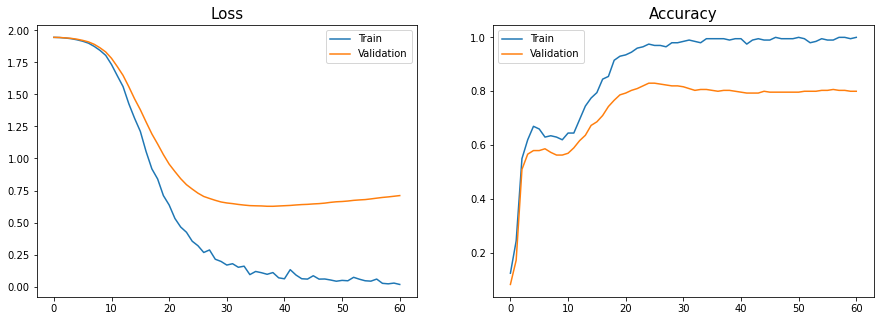

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(15,5))
ax = axes[0]
axes[0].plot(train_loss[::print_steps] + [train_loss[-1]], label='Train')
axes[0].plot(val_loss, label='Validation')
axes[1].plot(train_acc[::print_steps] + [train_acc[-1]], label='Train')
axes[1].plot(val_acc, label='Validation')
for ax,t in zip(axes, ['Loss', 'Accuracy']): ax.legend(), ax.set_title(t, size=15)

可以看到，GAT模型可以達到很好的效果。

### 模型預測

In [ ]:
#输出模型预测结果
output = model(features, adj)

samples = 10
idx_sample = idx_test[torch.randperm(len(idx_test))[:samples]]

idx2lbl = {v:k for k,v in lbl2idx.items()}
df = pd.DataFrame({'Real': [idx2lbl[e] for e in labels[idx_sample].tolist()],
                   'Pred': [idx2lbl[e] for e in output[idx_sample].argmax(1).tolist()]})
print(df)

                    Real                   Pred
0                 Theory                 Theory
1          Rule_Learning          Rule_Learning
2     Genetic_Algorithms     Genetic_Algorithms
3                 Theory                 Theory
4                 Theory                 Theory
5  Probabilistic_Methods  Probabilistic_Methods
6                 Theory                 Theory
7  Probabilistic_Methods  Probabilistic_Methods
8  Probabilistic_Methods  Probabilistic_Methods
9          Rule_Learning          Rule_Learning
